In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.options.display.max_columns = None

In [3]:
# 拆分列
def split_column(df, y="y"):
    try:
        X = df.drop(y, axis=1)
    except KeyError:
        raise KeyError("请在拆分列的参数中选择数据中有的字段")
    y = pd.DataFrame(df[y], columns=[y])
    return X, y

# 自定义函数
def check_nan(df_var):
    print("列数：{}，行数：{}".format(*df_var.shape))
    nan_result = df_var.isnull().sum(axis=0)
    col_name_list = df_var.columns.values
    result_dict = {k: v for k, v in zip(col_name_list, list(nan_result))}

    total = df_var.shape[0]
    
    nan_dict = dict()
    for rd in result_dict.items():
        print("{}: {}%".format(rd[0], round((rd[1]/total)*100, 2)))
        nan_dict[rd[0]] = round((rd[1]/total)*100, 2)

    return nan_dict

# 卡方分箱
def chi_merge(df, x_col, y_col, k=6):
    item = dict()
    pinf = float('inf')  # 正无穷大
    ninf = float('-inf')  # 负无穷大
    for col in x_col:
        print("[bin] Start {}".format(col))
        # 读取数据
        data = pd.concat([df[col], df[y_col]], axis=1)

        # 数据统计[feature1, class1, class2, class3]
        df_count = data.groupby(col)[y_col].value_counts().unstack().reset_index()
        df_count.fillna(0, inplace=True)
        df_count.index.name = 'index'
        n_class = df_count.shape[1] - 1
        num_interval = df_count.shape[0]

        # 计算卡方值，合并删除，直到行数为k
        while (num_interval > k):
            chi_values = []
            drop_index = []
            for i in range(num_interval - 1):  # 制作表格，行列分别求和，用于计算卡方值
                data_chi = df_count.iloc[i:i + 2, 1:].copy().reset_index(drop=True)
                data_chi['sum'] = data_chi.apply(lambda x: x.sum(), axis=1)
                data_chi.loc[2] = data_chi.apply(lambda x: x.sum())
                for index in range(2):
                    for j in range(n_class):  # 计算卡方值
                        data_chi.iloc[index, j] = (data_chi.iloc[index, j] -
                                                   data_chi.iloc[index, -1] * data_chi.iloc[2, j] / data_chi.iloc[
                                                       2, -1]) ** 2 / \
                                                  (data_chi.iloc[index, -1] * data_chi.iloc[2, j] / data_chi.iloc[
                                                      2, -1])
                chi_value = sum(data_chi.iloc[0:-1, 0:-1].sum())
                chi_values.append(chi_value)
            min_chi = min(chi_values)  # 最小卡方值
            for i in range(num_interval - 2, -1, -1):  # 合并最小卡方值的行
                if chi_values[i] == min_chi:
                    df_count.iloc[i, 1:] = df_count.iloc[i, 1:] + df_count.iloc[i + 1, 1:]
                    drop_index.append(i + 1)
            df_count.drop(drop_index, inplace=True)  # 丢弃最小卡方值的行
            num_interval = df_count.shape[0]
            df_count.index = [i for i in range(num_interval)]
            df_count.iloc[0, 0] = ninf

        binning_list = list(df_count[col])
        binning_list.remove(binning_list[0])
        print("auto split binning => {}".format(binning_list))
        item[col] = binning_list

    return item

In [5]:
# 导入数据
df = pd.read_csv('data/cs-training.csv')
df.head(15)

,Unnamed: 0,ID,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [4]:
# 查看各字段数量和类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
Unnamed: 0    150000 non-null int64
ID            150000 non-null int64
好坏客户          150000 non-null int64
可用额度比值        150000 non-null float64
年龄            150000 non-null int64
逾期30-59天笔数    150000 non-null int64
负债率           150000 non-null float64
月收入           120269 non-null float64
信贷数量          150000 non-null int64
逾期90天笔数       150000 non-null int64
固定资产贷款量       150000 non-null int64
逾期60-89天笔数    150000 non-null int64
家属数量          146076 non-null float64
dtypes: float64(4), int64(9)
memory usage: 14.9 MB


In [5]:
# 检查缺失值
_ = check_nan(df)

列数：150000，行数：13
逾期30-59天笔数: 0.0%
月收入: 19.82%
Unnamed: 0: 0.0%
负债率: 0.0%
家属数量: 2.62%
逾期90天笔数: 0.0%
可用额度比值: 0.0%
年龄: 0.0%
信贷数量: 0.0%
固定资产贷款量: 0.0%
逾期60-89天笔数: 0.0%
好坏客户: 0.0%
ID: 0.0%


In [6]:
# 查看数据基本情况
df.describe()

,Unnamed: 0,ID,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,74999.500000,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37499.750000,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,74999.500000,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112499.250000,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [7]:
# 填充缺失值：月收入使用平均值填充
df=df.fillna({'月收入':df['月收入'].mean()})
# 删除缺失值：家属数量缺失 2.62% 直接删掉有缺失的行
df=df.dropna()
# 删除与训练无关的变量
df = df.drop(["Unnamed: 0", "ID"], axis=1)
df.shape

(146076, 11)

In [8]:
# 结果填充、删除操作后，查看数据情况
df1 = df
df.head(15)

,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,1,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.000000,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,6670.221237,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.000000,8,0,0,0,0.0
9,0,0.189169,57,0,0.606291,23684.000000,9,0,4,0,2.0
10,0,0.644226,30,0,0.309476,2500.000000,5,0,0,0,0.0


In [9]:
# 再次确认缺失值情况
_ = check_nan(df)

列数：146076，行数：11
逾期30-59天笔数: 0.0%
月收入: 0.0%
可用额度比值: 0.0%
年龄: 0.0%
信贷数量: 0.0%
固定资产贷款量: 0.0%
逾期60-89天笔数: 0.0%
好坏客户: 0.0%
负债率: 0.0%
家属数量: 0.0%
逾期90天笔数: 0.0%


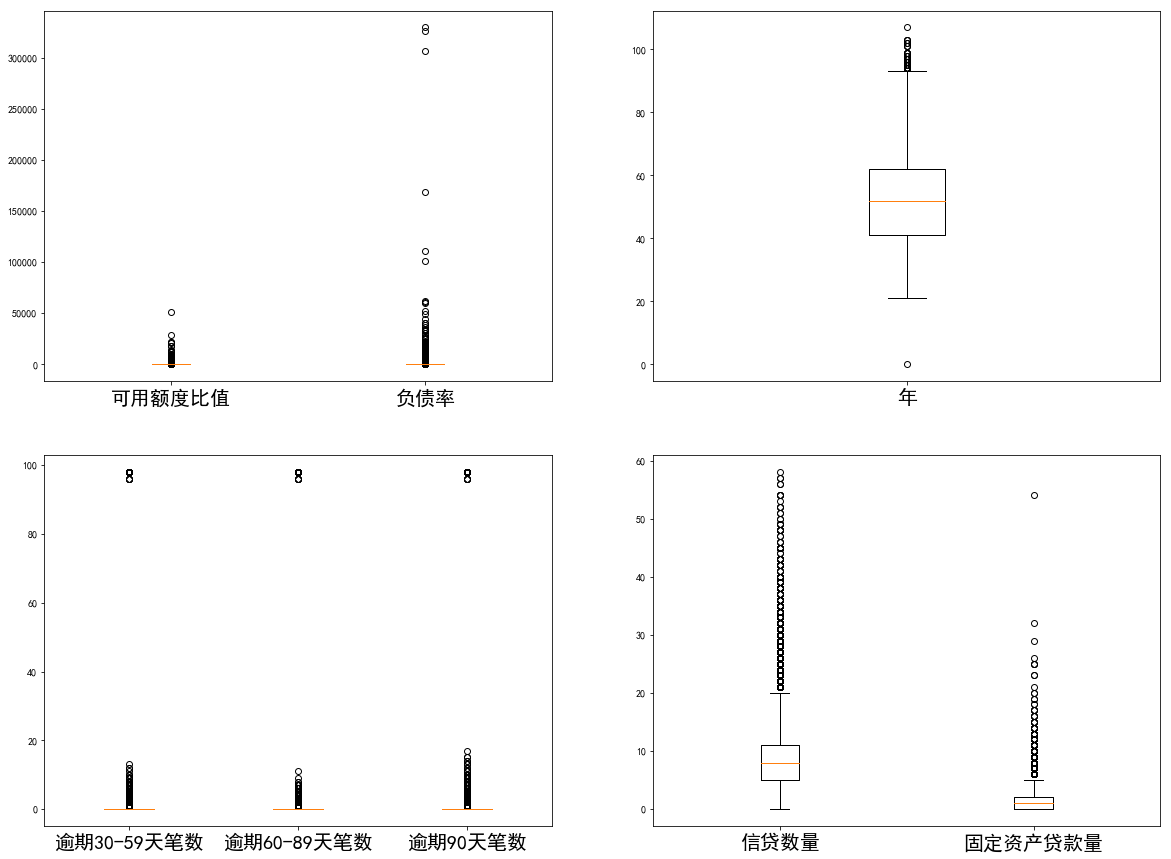

In [10]:
# 异常值分析
x1=df['可用额度比值']
x2=df['负债率']
x3=df1["年龄"]
x4=df1["逾期30-59天笔数"]
x5=df1["逾期60-89天笔数"]
x6=df1["逾期90天笔数"]
x7=df1["信贷数量"]
x8=df1["固定资产贷款量"]
fig=plt.figure(figsize=(20,15))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)
ax1.boxplot([x1,x2])
ax1.set_xticklabels(["可用额度比值","负债率"], fontsize=20)
ax2.boxplot(x3)
ax2.set_xticklabels("年龄", fontsize=20)
ax3.boxplot([x4,x5,x6])
ax3.set_xticklabels(["逾期30-59天笔数","逾期60-89天笔数","逾期90天笔数"], fontsize=20)
ax4.boxplot([x7,x8])
ax4.set_xticklabels(["信贷数量","固定资产贷款量"], fontsize=20)
plt.show()
# 异常值处理：消除不合逻辑的数据和超级离群的数据
# 可用额度比值应该小于1，
# 年龄为0的是异常值，
# 逾期天数笔数大于80的是超级离群数据，
# 固定资产贷款量大于50的是超级离群数据

In [11]:
# 处理异常值：过滤离群值，筛选出剩余部分数据
df1=df1[df1['可用额度比值']<1]
df1=df1[df1['年龄']>0]
df1=df1[df1['逾期30-59天笔数']<80]
df1=df1[df1['逾期60-89天笔数']<80]
df1=df1[df1['逾期90天笔数']<80]
df1=df1[df1['固定资产贷款量']<50]
df1.shape

(142559, 11)

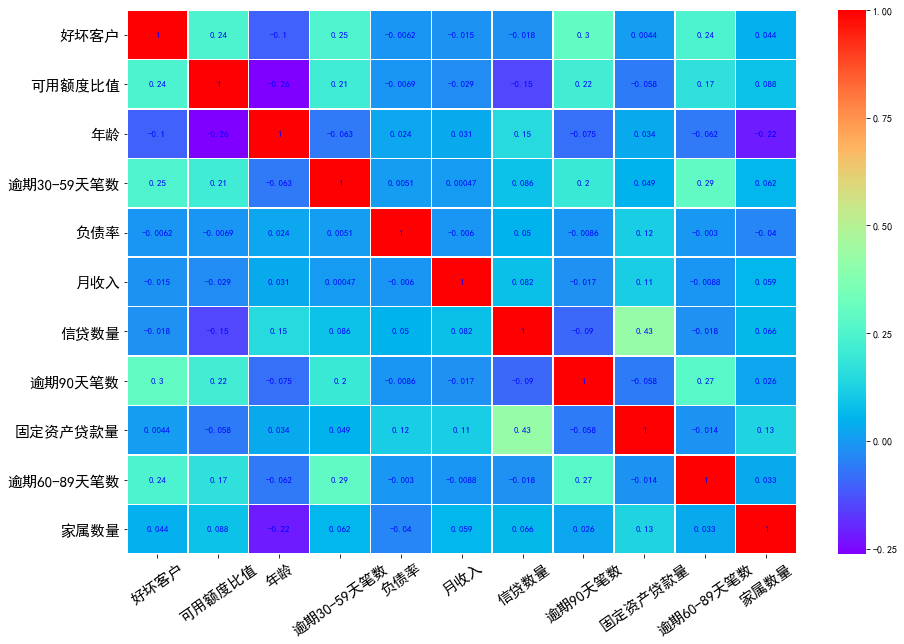

In [12]:
# 计算变量之间的相关系数
# 如果变量之间相关系数大于0.6，说明两个变量有较高的正相关性，
# 这种情况训练的模型会使模型失真，可以选择去掉其中一个变量
corr = df1.corr()
xticks = list(corr.index) # x轴标签
yticks = list(corr.index) # y轴标签
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1, 1, 1)
sns.heatmap(corr, annot=True, cmap="rainbow",ax=ax1,linewidths=.5, annot_kws={'size': 9, 'weight': 'bold', 'color': 'blue'})
ax1.set_xticklabels(xticks, rotation=35, fontsize=15)
ax1.set_yticklabels(yticks, rotation=0, fontsize=15)
plt.show()
# 本例中没有相关度较高的变量

In [13]:
def get_bins(cut_bins):
    bin_set = set()
    bin_list = []
    for i in list(cut_bins.index):
        i = str(i).replace("(", "").replace("]", "")
        i = i.split(",")
        i_a = float(i[0])
        i_b = float(i[1])
        bin_set.add(i_a)
        bin_set.add(i_b)
    bin_list = list(bin_set)
    bin_list = sorted(bin_list, reverse=False)
    print(bin_list)
    return bin_list

# 手动分箱：等频分箱+手动定义区间
cut1=pd.qcut(df1["可用额度比值"],4,labels=False)
cut_bins1 = pd.qcut(df1["可用额度比值"], 4).value_counts()
bins1 = get_bins(cut_bins1)

cut2=pd.qcut(df1["年龄"],8,labels=False)
cut_bins2=pd.qcut(df1["年龄"],8).value_counts()
bins2 = get_bins(cut_bins2)

bins3=[-1,0,1,3,5,13]
cut3=pd.cut(df1["逾期30-59天笔数"],bins3,labels=False)

cut4=pd.qcut(df1["负债率"],3,labels=False)
cut_bins4=pd.qcut(df1["负债率"],3).value_counts()
bins4 = get_bins(cut_bins4)

cut5=pd.qcut(df1["月收入"],4,labels=False)
cut_bins5=pd.qcut(df1["月收入"],4).value_counts()
bins5 = get_bins(cut_bins5)

cut6=pd.qcut(df1["信贷数量"],4,labels=False)
cut_bins6=pd.qcut(df1["信贷数量"],4).value_counts()
bins6 = get_bins(cut_bins6)

bins7=[-1, 0, 1, 3,5, 20]
cut7=pd.cut(df1["逾期90天笔数"],bins7,labels=False)

bins8=[-1, 0,1,2, 3, 33]
cut8=pd.cut(df1["固定资产贷款量"],bins8,labels=False)

bins9=[-1, 0, 1, 3, 12]
cut9=pd.cut(df1["逾期60-89天笔数"],bins9,labels=False)

bins10=[-1, 0, 1, 2, 3, 5, 21]
cut10=pd.cut(df1["家属数量"],bins10,labels=False)

key_list = ["可用额度比值", "年龄", "逾期30-59天笔数", "负债率", "月收入",
            "信贷数量", "逾期90天笔数", "固定资产贷款量", "逾期60-89天笔数", "家属数量"]
key_bin_list = [bins1, bins2, bins3, bins4, bins5, bins6, bins7, bins8, bins9, bins10]

items = []
for index, key in enumerate(key_list):
    bin_list = key_bin_list[index]
    for i in range(len(bin_list)):
        if i != (len(bin_list) - 1):
            item = dict()
            item["变量名称"] = key
            item["区间"] = "[{},{}]".format(bin_list[i], bin_list[i+1])
            items.append(item)

score_card = pd.DataFrame(items, columns=["变量名称", "区间"])
score_card.head(10)

[-0.001, 0.0295, 0.148, 0.521, 1.0]
[20.999, 35.0, 41.0, 47.0, 52.0, 57.0, 63.0, 70.0, 107.0]
[-0.001, 0.234, 0.542, 329664.0]
[-0.001, 3872.0, 6494.0, 7500.0, 3008750.0]
[-0.001, 5.0, 8.0, 11.0, 57.0]


,变量名称,区间
0,可用额度比值,"[-0.001,0.0295]"
1,可用额度比值,"[0.0295,0.148]"
2,可用额度比值,"[0.148,0.521]"
3,可用额度比值,"[0.521,1.0]"
4,年龄,"[20.999,35.0]"
5,年龄,"[35.0,41.0]"
6,年龄,"[41.0,47.0]"
7,年龄,"[47.0,52.0]"
8,年龄,"[52.0,57.0]"
9,年龄,"[57.0,63.0]"


In [34]:
cut_bins2

(57.0, 63.0]      19978
(20.999, 35.0]    19824
(41.0, 47.0]      19741
(47.0, 52.0]      17910
(52.0, 57.0]      16891
(70.0, 107.0]     16349
(35.0, 41.0]      15971
(63.0, 70.0]      15895
Name: 年龄, dtype: int64

In [14]:
# 计算对应区间和变量的WOE值

rate=df1["好坏客户"].sum()/(df1["好坏客户"].count()-df1["好坏客户"].sum())
def get_woe_data(cut):
    grouped=df1["好坏客户"].groupby(cut,as_index = True).value_counts()
    woe=np.log(grouped.unstack().iloc[:,1]/grouped.unstack().iloc[:,0]/rate)
    return woe

woe_list = []
cut1_woe=get_woe_data(cut1)
cut2_woe=get_woe_data(cut2)
cut3_woe=get_woe_data(cut3)
cut4_woe=get_woe_data(cut4)
cut5_woe=get_woe_data(cut5)
cut6_woe=get_woe_data(cut6)
cut7_woe=get_woe_data(cut7)
cut8_woe=get_woe_data(cut8)
cut9_woe=get_woe_data(cut9)
cut10_woe=get_woe_data(cut10)

woe_list = list(cut1_woe) + list(cut2_woe) + list(cut3_woe) + list(cut4_woe) + list(cut5_woe) + list(cut6_woe) + list(cut7_woe) + list(cut8_woe) + list(cut9_woe) + list(cut10_woe)

score_card["WOE"] = woe_list

score_card.head(10)

,变量名称,区间,WOE
0,可用额度比值,"[-0.001,0.0295]",-1.203637
1,可用额度比值,"[0.0295,0.148]",-1.135436
2,可用额度比值,"[0.148,0.521]",-0.247395
3,可用额度比值,"[0.521,1.0]",1.044468
4,年龄,"[20.999,35.0]",0.518166
5,年龄,"[35.0,41.0]",0.316890
6,年龄,"[41.0,47.0]",0.246969
7,年龄,"[47.0,52.0]",0.166515
8,年龄,"[52.0,57.0]",-0.025004
9,年龄,"[57.0,63.0]",-0.396028


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


Text(0, 0.5, 'IV')

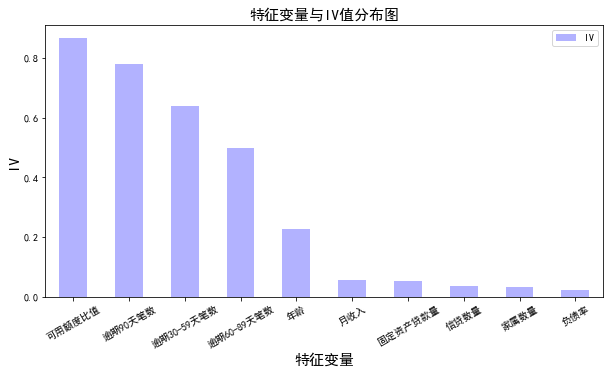

In [15]:
def get_IV_data(cut,cut_woe):
    grouped=df1["好坏客户"].groupby(cut,as_index = True).value_counts()
    cut_IV=((grouped.unstack().iloc[:,1]/df1["好坏客户"].sum()-grouped.unstack().iloc[:,0]/(df1["好坏客户"].count()-df1["好坏客户"].sum()))*cut_woe).sum()    
    return cut_IV
#计算各分组的IV值 一般取IV值大于0.02的变量用作训练
cut1_IV=get_IV_data(cut1,cut1_woe)
cut2_IV=get_IV_data(cut2,cut2_woe)
cut3_IV=get_IV_data(cut3,cut3_woe)
cut4_IV=get_IV_data(cut4,cut4_woe)
cut5_IV=get_IV_data(cut5,cut5_woe)
cut6_IV=get_IV_data(cut6,cut6_woe)
cut7_IV=get_IV_data(cut7,cut7_woe)
cut8_IV=get_IV_data(cut8,cut8_woe)
cut9_IV=get_IV_data(cut9,cut9_woe)
cut10_IV=get_IV_data(cut10,cut10_woe)
IV=pd.DataFrame([cut1_IV,cut2_IV,cut3_IV,cut4_IV,cut5_IV,cut6_IV,cut7_IV,cut8_IV,cut9_IV,cut10_IV],index=['可用额度比值','年龄','逾期30-59天笔数','负债率','月收入','信贷数量','逾期90天笔数','固定资产贷款量','逾期60-89天笔数','家属数量'],columns=['IV'])
IV = IV.sort_index(by = ["IV"],ascending = [False]) 
iv=IV.plot.bar(color='b',alpha=0.3,rot=30,figsize=(10,5),fontsize=(10))
iv.set_title('特征变量与IV值分布图',fontsize=(15))
iv.set_xlabel('特征变量',fontsize=(15))
iv.set_ylabel('IV',fontsize=(15))

In [16]:
IV.sort_index(by = ["IV"],ascending = [False])  

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,IV
可用额度比值,0.867677
逾期90天笔数,0.780782
逾期30-59天笔数,0.638915
逾期60-89天笔数,0.497545
年龄,0.226285
月收入,0.056417
固定资产贷款量,0.052406
信贷数量,0.035331
家属数量,0.033580
负债率,0.021881


In [17]:
# 将之前各个变量的值，按照指定区间的WOE值进行填充
df_new=pd.DataFrame()   #新建df_new存放woe转换后的数据
def replace_data(cut,cut_woe):
    a=[]
    for i in cut.unique():
        a.append(i)
        a.sort()
    for m in range(len(a)):
        cut.replace(a[m],cut_woe.values[m],inplace=True)
    return cut
df_new["好坏客户"]=df1["好坏客户"]
df_new["可用额度比值"]=replace_data(cut1,cut1_woe)
df_new["年龄"]=replace_data(cut2,cut2_woe)
df_new["逾期30-59天笔数"]=replace_data(cut3,cut3_woe)
df_new["负债率"]=replace_data(cut4,cut4_woe)
df_new["月收入"]=replace_data(cut5,cut5_woe)
df_new["信贷数量"]=replace_data(cut6,cut6_woe)
df_new["逾期90天笔数"]=replace_data(cut7,cut7_woe)
df_new["固定资产贷款量"]=replace_data(cut8,cut8_woe)
df_new["逾期60-89天笔数"]=replace_data(cut9,cut9_woe)
df_new["家属数量"]=replace_data(cut10,cut10_woe)
df_new.head()

,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,1,1.044468,0.246969,1.701683,0.191066,-0.321369,0.045474,-0.345338,0.665870,-0.244603,0.197472
1,0,1.044468,0.316890,-0.476517,-0.151014,0.289489,0.222781,-0.345338,0.197418,-0.244603,0.097683
2,0,1.044468,0.316890,0.899640,-0.151014,0.289489,0.222781,1.990279,0.197418,-0.244603,-0.150675
3,0,-0.247395,0.518166,-0.476517,-0.151014,0.289489,0.222781,-0.345338,0.197418,-0.244603,-0.150675
4,0,1.044468,0.166515,0.899640,-0.151014,-0.321369,-0.255957,-0.345338,-0.235787,-0.244603,-0.150675


In [39]:
# 使用逻辑回归算法训练，求解变量权重
x, y = split_column(df_new, "好坏客户")  # 拆分列

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.6,random_state=0)
model=LogisticRegression()
clf=model.fit(x_train,y_train)
print('模型准确率：{}'.format(clf.score(x_test,y_test)))

模型准确率：0.9418841189674523


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
x.head()

,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,1.044468,0.246969,1.701683,0.191066,-0.321369,0.045474,-0.345338,0.665870,-0.244603,0.197472
1,1.044468,0.316890,-0.476517,-0.151014,0.289489,0.222781,-0.345338,0.197418,-0.244603,0.097683
2,1.044468,0.316890,0.899640,-0.151014,0.289489,0.222781,1.990279,0.197418,-0.244603,-0.150675
3,-0.247395,0.518166,-0.476517,-0.151014,0.289489,0.222781,-0.345338,0.197418,-0.244603,-0.150675
4,1.044468,0.166515,0.899640,-0.151014,-0.321369,-0.255957,-0.345338,-0.235787,-0.244603,-0.150675


In [41]:
y.head()

,好坏客户
0,1
1,0
2,0
3,0
4,0


0.8399091042596365


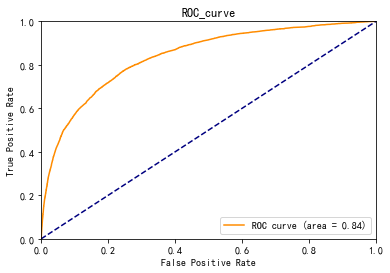

In [42]:
# 计算AUC值
y_prob = model.predict_proba(x_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:, 1])
auc_value = metrics.auc(fpr, tpr)  # 计算auc
print(auc_value)

plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()


In [43]:
# 特征权值系数，后面转换为打分规则时会用到
coe=clf.coef_

items = []
for index, c in enumerate(coe[0]):
    item = dict()
    item["变量名称"] = key_list[index]
    item["模型权重"] = c
    items.append(item)

coef_df = pd.DataFrame(items, columns=["变量名称", "模型权重"])
coef_df

,变量名称,模型权重
0,可用额度比值,0.619894
1,年龄,0.431344
2,逾期30-59天笔数,0.564306
3,负债率,1.257495
4,月收入,0.571757
5,信贷数量,0.217925
6,逾期90天笔数,0.590601
7,固定资产贷款量,0.637542
8,逾期60-89天笔数,0.465662
9,家属数量,0.370910


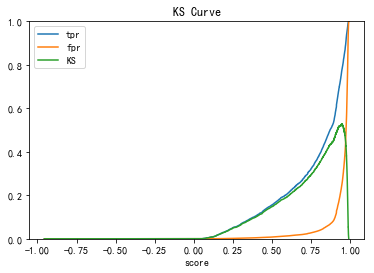

<Figure size 1440x1440 with 0 Axes>

In [44]:
# 计算KS值
fig, ax = plt.subplots()
ax.plot(1 - threshold, tpr, label='tpr') # ks曲线要按照预测概率降序排列，所以需要1-threshold镜像
ax.plot(1 - threshold, fpr, label='fpr')
ax.plot(1 - threshold, tpr-fpr,label='KS')
plt.xlabel('score')
plt.title('KS Curve')
plt.ylim([0.0, 1.0])
plt.figure(figsize=(20,20))
legend = ax.legend(loc='upper left')
plt.show()

In [45]:
# 计算KS值
max(tpr-fpr)

0.5274346008328302

In [46]:
# 假设好坏比为20的时候分数为600分，每高20分好坏比翻一倍
# 现在我们求每个变量不同woe值对应的分数刻度可得：
factor = 20 / np.log(2)
offset = 600 - 20 * np.log(20) / np.log(2)
def get_score(coe,woe,factor):
    scores=[]
    for w in woe:
        score=round(coe*w*factor,0)
        scores.append(score)
    return scores
x1 = get_score(coe[0][0], cut1_woe, factor)
x2 = get_score(coe[0][1], cut2_woe, factor)
x3 = get_score(coe[0][2], cut3_woe, factor)
x4 = get_score(coe[0][3], cut4_woe, factor)
x5 = get_score(coe[0][4], cut5_woe, factor)
x6 = get_score(coe[0][5], cut6_woe, factor)
x7 = get_score(coe[0][6], cut7_woe, factor)
x8 = get_score(coe[0][7], cut8_woe, factor)
x9 = get_score(coe[0][8], cut9_woe, factor)
x10 = get_score(coe[0][9], cut10_woe, factor)
print("可用额度比值对应的分数:{}".format(x1))
print("年龄对应的分数:{}".format(x2))
print("逾期30-59天笔数对应的分数:{}".format(x3))
print("负债率对应的分数:{}".format(x4))
print("月收入对应的分数:{}".format(x5))
print("信贷数量对应的分数:{}".format(x6))
print("逾期90天笔数对应的分数:{}".format(x7))
print("固定资产贷款量对应的分数:{}".format(x8))
print("逾期60-89天笔数对应的分数:{}".format(x9))
print("家属数量对应的分数:{}".format(x10))

x_all = x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10
score_card["评分刻度"] = x_all

# 查看评分标准
score_card.head(20)

可用额度比值对应的分数:[-22.0, -20.0, -4.0, 19.0]
年龄对应的分数:[6.0, 4.0, 3.0, 2.0, -0.0, -5.0, -11.0, -13.0]
逾期30-59天笔数对应的分数:[-8.0, 15.0, 28.0, 38.0, 43.0]
负债率对应的分数:[-5.0, -2.0, 7.0]
月收入对应的分数:[5.0, 2.0, -3.0, -5.0]
信贷数量对应的分数:[1.0, -2.0, -1.0, 0.0]
逾期90天笔数对应的分数:[-6.0, 34.0, 47.0, 56.0, 56.0]
固定资产贷款量对应的分数:[4.0, -4.0, -3.0, 1.0, 12.0]
逾期60-89天笔数对应的分数:[-3.0, 25.0, 36.0, 40.0]
家属数量对应的分数:[-2.0, 1.0, 2.0, 3.0, 4.0, 7.0]


,变量名称,区间,WOE,评分刻度
0,可用额度比值,"[-0.001,0.0295]",-1.203637,-22.0
1,可用额度比值,"[0.0295,0.148]",-1.135436,-20.0
2,可用额度比值,"[0.148,0.521]",-0.247395,-4.0
3,可用额度比值,"[0.521,1.0]",1.044468,19.0
4,年龄,"[20.999,35.0]",0.518166,6.0
5,年龄,"[35.0,41.0]",0.316890,4.0
6,年龄,"[41.0,47.0]",0.246969,3.0
7,年龄,"[47.0,52.0]",0.166515,2.0
8,年龄,"[52.0,57.0]",-0.025004,-0.0
9,年龄,"[57.0,63.0]",-0.396028,-5.0


In [47]:
# 计算测试集中每个用户的最终得分
def compute_score(series,bins,score):
    list = []
    i = 0
    while i < len(series):
        value = series[i]
        j = len(bins) - 2
        m = len(bins) - 2
        while j >= 0:
            if value >= bins[j]:
                j = -1
            else:
                j -= 1
                m -= 1
        list.append(score[m])
        i += 1
    return list

# 加载测试集
path2='zh/cs-test.csv'
test1 = pd.read_csv(path2)

In [49]:
test1.head()

,Unnamed: 0,ID,好坏客户,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量
0,0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [50]:
test1, t_ID = split_column(test1, "ID")
test1 = test1.drop(["好坏客户", "Unnamed: 0"], axis=1)

In [51]:
# 计算测试集中每个用户的最终得分
test1['x1'] = pd.Series(compute_score(test1['可用额度比值'], bins1, x1))
test1['x2'] = pd.Series(compute_score(test1['年龄'], bins2, x2))
test1['x3'] = pd.Series(compute_score(test1['逾期30-59天笔数'], bins3, x3))
test1['x4'] = pd.Series(compute_score(test1['负债率'], bins4, x4))
test1['x5'] = pd.Series(compute_score(test1['月收入'], bins5, x5))
test1['x6'] = pd.Series(compute_score(test1['信贷数量'], bins6, x6))
test1['x7'] = pd.Series(compute_score(test1['逾期90天笔数'], bins7, x7))
test1['x8'] = pd.Series(compute_score(test1['固定资产贷款量'], bins8, x8))
test1['x9'] = pd.Series(compute_score(test1['逾期60-89天笔数'], bins9, x9))
test1['x10'] = pd.Series(compute_score(test1['家属数量'], bins10, x10))
test1['Score'] = test1['x1']+test1['x2']+test1['x3']+test1['x4']+test1['x5']+test1['x6']+test1['x7']+test1['x8']+test1['x9']+test1['x10']+600

test1.head(10)

,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Score
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,19.0,3.0,15.0,-5.0,2.0,1.0,34.0,-4.0,25.0,1.0,691.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,-4.0,-5.0,15.0,-2.0,-5.0,0.0,34.0,12.0,25.0,3.0,673.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,-20.0,-5.0,15.0,7.0,2.0,0.0,34.0,-3.0,25.0,3.0,658.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,-4.0,4.0,28.0,7.0,5.0,-2.0,34.0,1.0,25.0,1.0,699.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,19.0,6.0,15.0,-5.0,5.0,1.0,34.0,-4.0,25.0,2.0,698.0
5,0.509791,63,0,0.342429,4140.0,4,0,0,0,1.0,-4.0,-11.0,15.0,-2.0,2.0,1.0,34.0,-4.0,25.0,2.0,658.0
6,0.587778,50,0,1048.000000,0.0,5,0,0,0,3.0,19.0,2.0,15.0,7.0,5.0,-2.0,34.0,-4.0,25.0,4.0,705.0
7,0.046149,79,1,0.369170,3301.0,8,0,1,0,1.0,-20.0,-13.0,28.0,-2.0,5.0,-1.0,34.0,-3.0,25.0,2.0,655.0
8,0.013527,68,0,2024.000000,NaN,4,0,1,0,0.0,-22.0,-11.0,15.0,7.0,-5.0,1.0,34.0,-3.0,25.0,1.0,642.0
9,1.000000,23,98,0.000000,0.0,0,98,0,98,0.0,19.0,6.0,43.0,-5.0,5.0,1.0,56.0,-4.0,40.0,1.0,762.0


In [52]:
test1.head(100)

,可用额度比值,年龄,逾期30-59天笔数,负债率,月收入,信贷数量,逾期90天笔数,固定资产贷款量,逾期60-89天笔数,家属数量,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Score
0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,19.0,3.0,15.0,-5.0,2.0,1.0,34.0,-4.0,25.0,1.0,691.0
1,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,-4.0,-5.0,15.0,-2.0,-5.0,0.0,34.0,12.0,25.0,3.0,673.0
2,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,-20.0,-5.0,15.0,7.0,2.0,0.0,34.0,-3.0,25.0,3.0,658.0
3,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,-4.0,4.0,28.0,7.0,5.0,-2.0,34.0,1.0,25.0,1.0,699.0
4,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,19.0,6.0,15.0,-5.0,5.0,1.0,34.0,-4.0,25.0,2.0,698.0
5,0.509791,63,0,0.342429,4140.0,4,0,0,0,1.0,-4.0,-11.0,15.0,-2.0,2.0,1.0,34.0,-4.0,25.0,2.0,658.0
6,0.587778,50,0,1048.000000,0.0,5,0,0,0,3.0,19.0,2.0,15.0,7.0,5.0,-2.0,34.0,-4.0,25.0,4.0,705.0
7,0.046149,79,1,0.369170,3301.0,8,0,1,0,1.0,-20.0,-13.0,28.0,-2.0,5.0,-1.0,34.0,-3.0,25.0,2.0,655.0
8,0.013527,68,0,2024.000000,NaN,4,0,1,0,0.0,-22.0,-11.0,15.0,7.0,-5.0,1.0,34.0,-3.0,25.0,1.0,642.0
9,1.000000,23,98,0.000000,0.0,0,98,0,98,0.0,19.0,6.0,43.0,-5.0,5.0,1.0,56.0,-4.0,40.0,1.0,762.0


In [56]:
test1.to_csv("李谦_gbk.csv", encoding="gbk")